# 시계열 분석
- 자주 출제 되는 분야
- 시계열분석 + 군집분석 의 혼합형 문제도 나옴
- 해당 분석의 과정과 의의를 이해하는지도 물어 보고 있음
- ARIMA 모형에 대한 상세 설명
- 시계열 분석이란, 시간의 흐름에 따라 기록된 데이터를 바탕으로 미래의 변화에 대한 추세를 분석하는 방법
- 시간에 따라 데이터의 추세가 어떠한지 시간 외에 어떤한 외부요인이 데이터에 영향을 미치는지 나누어 생각할 수 있어야 한다.

## 시계열 분해
- 추세(Trend), 계절성(Seasonality), 잔차(Residual)로 분해
- 시간의 요인은, 추세, 계절성, 외부요인은, 잔차(불규칙) 요인

### 모형 판단
- 시계열의 주기적 반복/계절성이 있는지에 따라 Additive 모형과 Multiplicative 모형 중 어느쪽이 적합 한지 판단
- Additive 모형 : 추세와 계절성이 별개로 존재
- Multiplicative 모형 : 추세에 따라 계절성이 있는 경우'

<img src="img/07-48.png" width="800"/>

### 파이썬을 활용한 시계열 분해

In [7]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./data/arima_data.csv', names=['day', 'price'])
df.head()

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [8]:
df['day'] = pd.to_datetime(df['day'])
df.set_index('day', inplace=True)
df.head()

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190
2013-04-01,5783
2013-05-01,6298


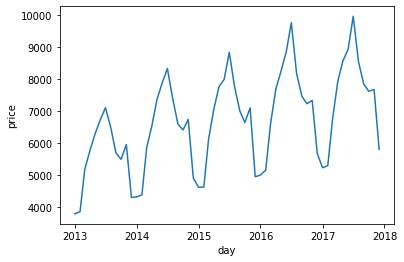

In [9]:
import matplotlib.pyplot as plt

plt.plot(df)
plt.xlabel('day')
plt.ylabel('price')
plt.show()

- 추세에 따라 계절성 존재 -> multiplicative 
- Trend와 Seasonal 이 명확히 존재
- 뷸규칙 요인은 거의 없음

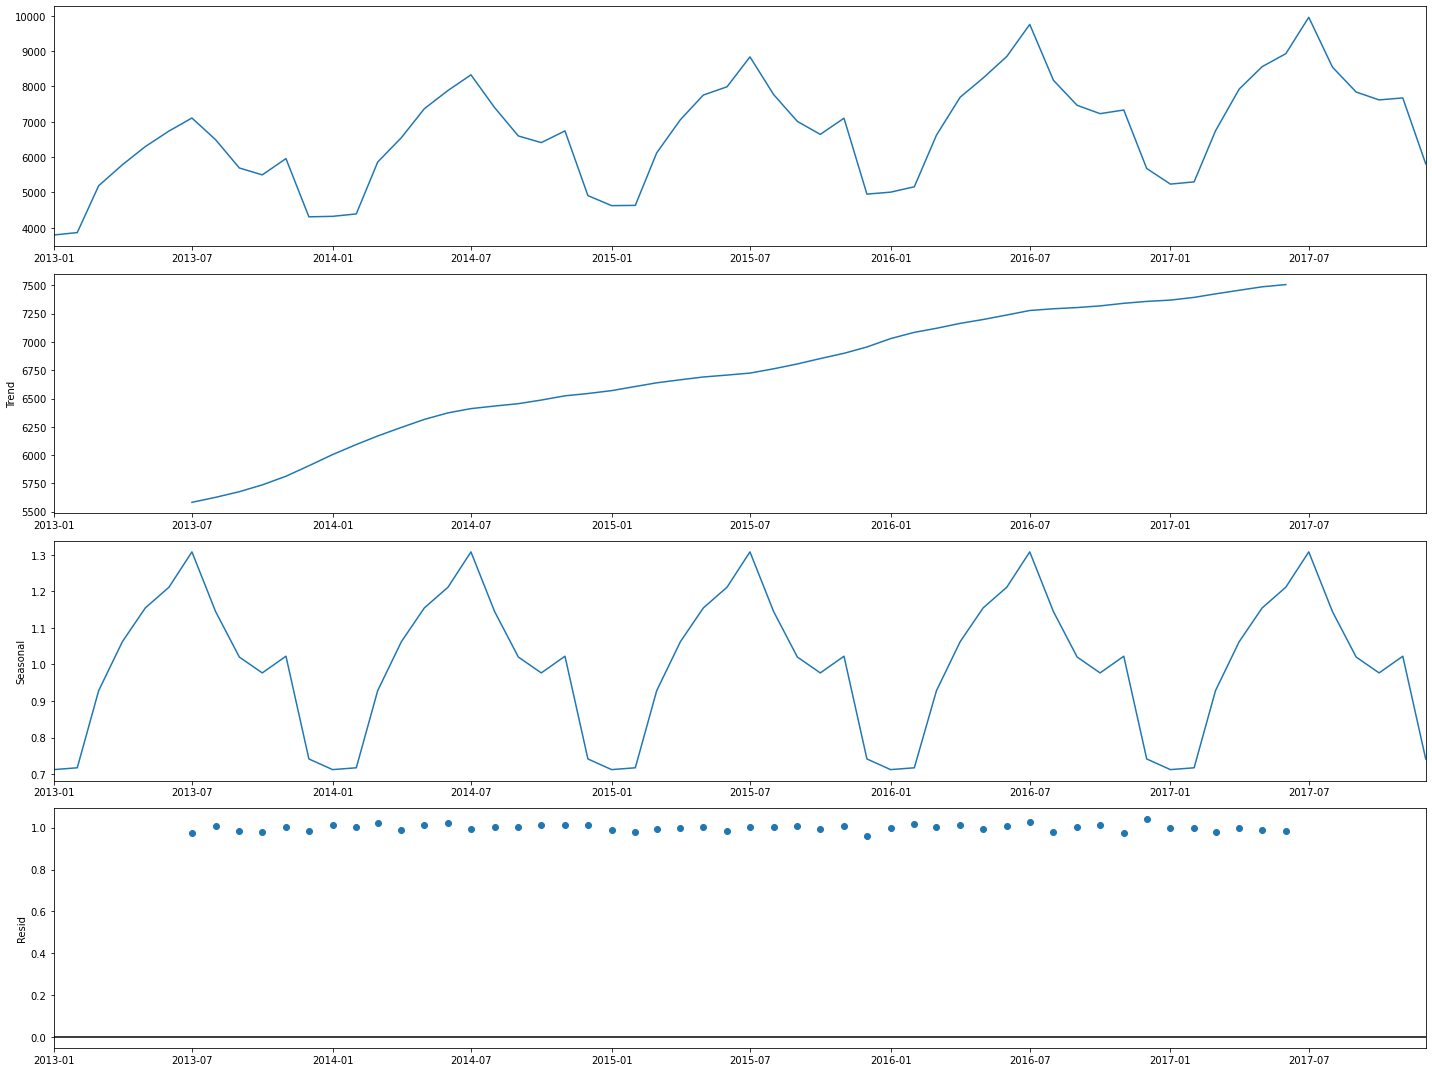

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = [20, 15]
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

## 정상성 변환
- 시험에서는 ARIMA 모델을 사용하는 것을 추천
- 성능 + 해석력이 좋기 때문
- ARIMA는 AR(Auto-Regression) 모형과 MA(Moving Average) 모형을 합친 모형으로 두 모델을 모두 이해해야 적용가능

### 정상성의 개념
- 평균, 분산이 시간에 따라 일정한 성질을 가지고 있다는 것
- 즉, 시계열 데이터 특성이 시간이 흘러도 변하지 않는 상태
- 추세, 계절성이 있는 데이터는 비정상 시계열이라 하며, 정상 시계열로 변화 해주어야 ARIMA를 적용할수 있다.
- 변환 방법으로는, 로그 변환과 차분이 있다.

### 로그 변환 : 분산 (등락폭)을 일정하게 바꿈

<img src="img/07-49.png" width="800"/>

- 로그변환은 위의 왼쪽과 같이 분산(변동폭)이 일정하지 않은 경우에 사용

### 차분 : 추세 · 계절성 제거

<img src="img/07-50.png" width="800"/>

- 로그변환 후, 추세와 계절성이 존재하는 경우 이를 없애기 위해 사용

### 파이썬을 활용한 데이터 전처리
- 정상성 검정을 위해 Augmented Dickey-Fuller (ADF) Test를 수행 한다.

- ADF test 가설
  - 귀무가설 : 데이터가 정상성을 갖지 않는다.
  - 대립가설 : 데이터가 정상성을 갖는다. <br> <br>

- adfuller 함수
```python
    adfuller(x, maxlag, regression, autolag)
```
<img src="img/07-51.png" width="800"/>

- return 값
    - t-statistic : 해당 테스트는 t-통계량 사용
    - p-value : 유의수준 보다 작으면 귀무가설 기각 <br><br>
    
- 앞선 예제의 데이터를 train, test로 분리 한 후, 정상성 검정    

In [5]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd 

df = pd.read_csv('./data/arima_data.csv', names=['day', 'price'])
df['day'] = pd.to_datetime(df['day'])
df.set_index('day', inplace=True)
training = df[:'2016-12-01']
test = df.drop(training.index)

In [6]:
adf = adfuller(training, regression='ct')
print(f'ADF Statistic : {adf[0]}')
print(f'p-value : {adf[1]}')

ADF Statistic : -1.999719934132788
p-value : 0.6015863303794134


- 우상향 트랜드, ct (상수항 1차 추세) 사용
- p-value > 0.05, 귀무가설(정상성을 갖지 않는다) 채택
- 1차 차분 혹은 로그변환 수행 필요

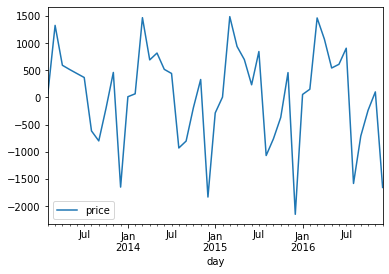

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_df = training.diff(1).dropna()
diff_df.plot();

In [8]:
adf = adfuller(diff_df, regression='c')
print(f'ADF Statistic : {adf[0]}')
print(f'p-value : {adf[1]}')

ADF Statistic : -12.094547576926388
p-value : 2.0851606399614422e-22


- 우상향 패턴을 보이지 않아 adfuller 함수의 regression은 'c' (상수항) 을 사용
- p-value는 0.05보다 작아, 귀무가설 기각, 정상 시계열로 변환 되었음
- 이제 AR과 MA 모형을 적용 해보자

## AR 모형과 MA 모형
### AR(Auto Regressive)
#### 개념 
- AR 모형은 자기회귀모형이란 뜻으로, 현 시점의 데이터를 이전 데이터들의 상관성으로 나타내는 모형
- 과거의 값이 현재의 값에 얼마나 영향을 미쳤는지 파악하는 것
- 만약 과거의 값이 현재의 값에 영향을 미치지 않는다면, 해당 모형의 성능은 낮아 진다.
- <u><b><i>최적의 성능을 가지는 모델을 만들 수 있는 과거값(p)</i></b></u>을 찾게 되는데, 이를 AR(p) 모형이라 한다.
#### ACF(Auto Correlation Fuction): "지금의 나"는 "몇년 전의 나" 들로부터 얼마나 영향받았니?
- ACF는 자기상관 함수로, 이 값은 시차가 다른 자기상관성을 의미
- ACF값을 시차에 따른 그래프로 시각화 해보면, 최적의 p를 찾을 수 있다.
- 비정상 시계열의 경우 ACF 값은 느리게 0에 접근하며 양수의 값을 가질 수 있다.
    - 비정상 시계열은, 추세나 계절성을 갖고 있어, 가장 최근의 값이 상관성이 크고, 과거 값은 상대적으로 상관성이 낮을 것. 따라서 느리게 0에 수렴
- 정상 시계열의 경우 ACF 값은 빠르게 0으로 수렴하며, 0으로 수렴할 때가 시차 p 값으로 설정
#### 파이썬을 활용한 AR 모형의 p 값 찾기

<Figure size 1440x720 with 0 Axes>

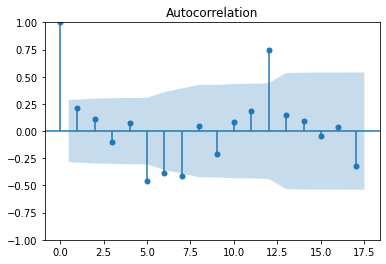

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_acf(diff_df);

- acf에서 2차 이후 0에 수렴, 따라서 AR 모형의 최적의 p값은 2로 설정

### MA(Moving Average)
#### 개념
- MA 모형은 과거의 예측 오차들의 가중이동평균으로 현재 시점의 데이터를 포현하는 모형
- 과거의 예측 오차를 이용해 미래를 예측하는 모형
- 과거의 예측 오차들에 따라 가중이동평균이 달라짐
- 최적의 모형이 되는 구간을 구하는 것이 중요
- MA 모형이 최적이 되게끔 하는 변수 값이 q이며, 이를 모형 MA(q) 모형이라고 한다.
#### PACF(Partial Auto Correlation Fuction) :"지금의 나"는 "몇년 전의 나"와 얼마나 비슷했니?
- PACF는 편자기상관 함수
- PACF는 ACF와는 다르게 시차가 다른 두 시계열 데이터 간의 순수 한 상호 연관성을 나타낸다.
- ACF는 과거 시점 까지의 데이터로 현시점의 상관성, PACF는 과거의 특정한 한 시점의 데이터와 현재 시점의 데이터의 상관성
- PACF 값이 0에 수렴할 때 q 값을 MA 모형의 q 값으로 설정
#### 파이썬을 활용한 AR 모형의 q값 찾기

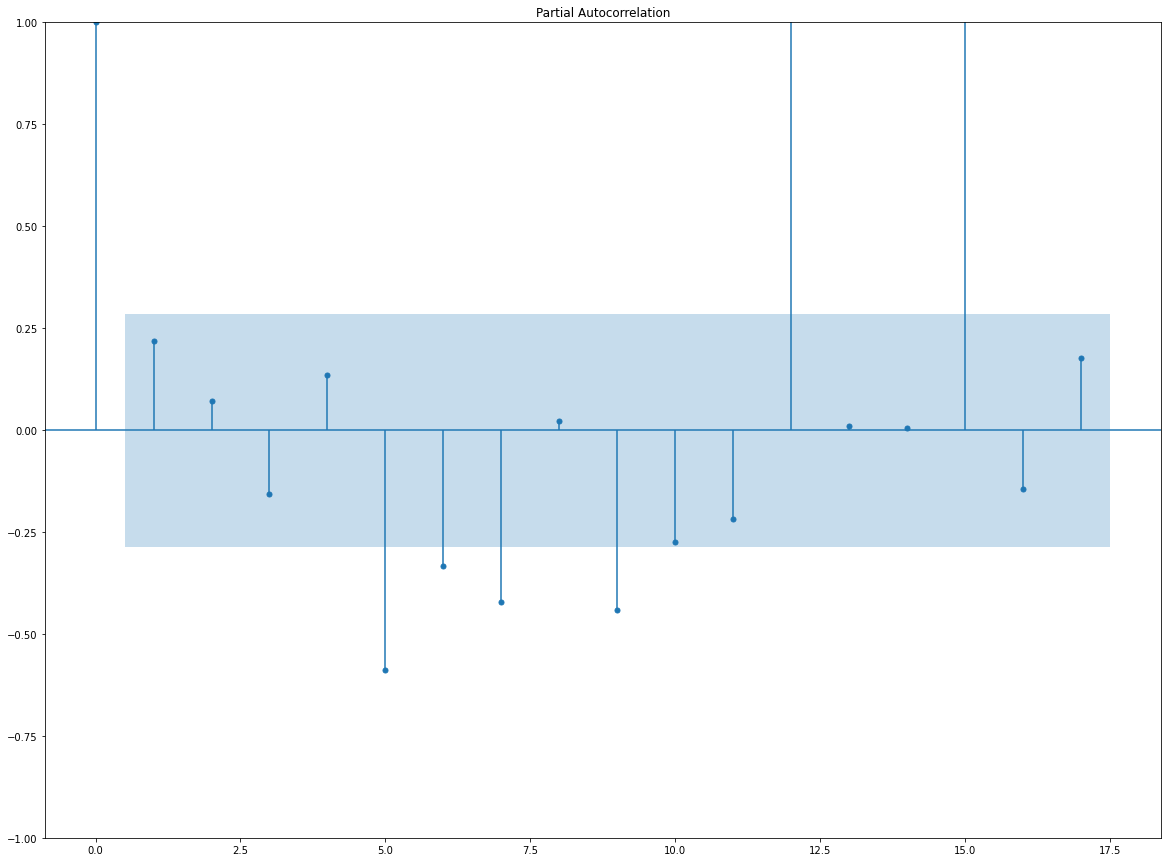

In [20]:
import warnings
warnings.filterwarnings('ignore')

plot_pacf(diff_df)
plt.show()

- 시차 2 이후 0에 수렴, 따라서 MA(2) 모형 임

## ARIMA(Auto-Regressive Intergrated Moving Average)
### 개념
- ARIMA는 비정상적 시계열 자료에 대해 분석하는 모형
- 차분을 이용해 비정상 시계열을 정상으로 만든다
- 그리고 AR, MA 두 모형을 결합하여, 과거 시점의 데이터로 현재 혹은 미래의 시점의 데이터를 예측
- ARIMA 모형의 파라미터로는 (p, d, q) 사용
- 시계열 자로 외에 다른 자료가 없을 때, 그 변동 상태를 확인할 수 있다는 장점을 갖고 있으며
- 어떠한 시계열에도 적용이 가능한 모델

### ARIMA 파이썬 실습
- p는 ACF로, d는 차분의 횟수, q는 PACF로 최적화 가능
- AIC 값을 비교하여 최적의 모델을 찾는 방법도 있음

#### ARIMA 함수 호출
``` python
    from statsmodels.tsa.arima.model import ARIMA
```
#### 주요 매개변수

<img src="img/07-52.png" width="800"/>


#### 파이썬 실습
- ARIMA 모델에 p,d,q (2,1,2)를 적용하여 예측해 보자

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd 

df = pd.read_csv('./data/arima_data.csv', names=['day', 'price'])
df['day'] = pd.to_datetime(df['day'])
df.set_index('day', inplace=True)
training = df[:'2016-12-01']
test = df.drop(training.index)

<AxesSubplot:xlabel='day'>

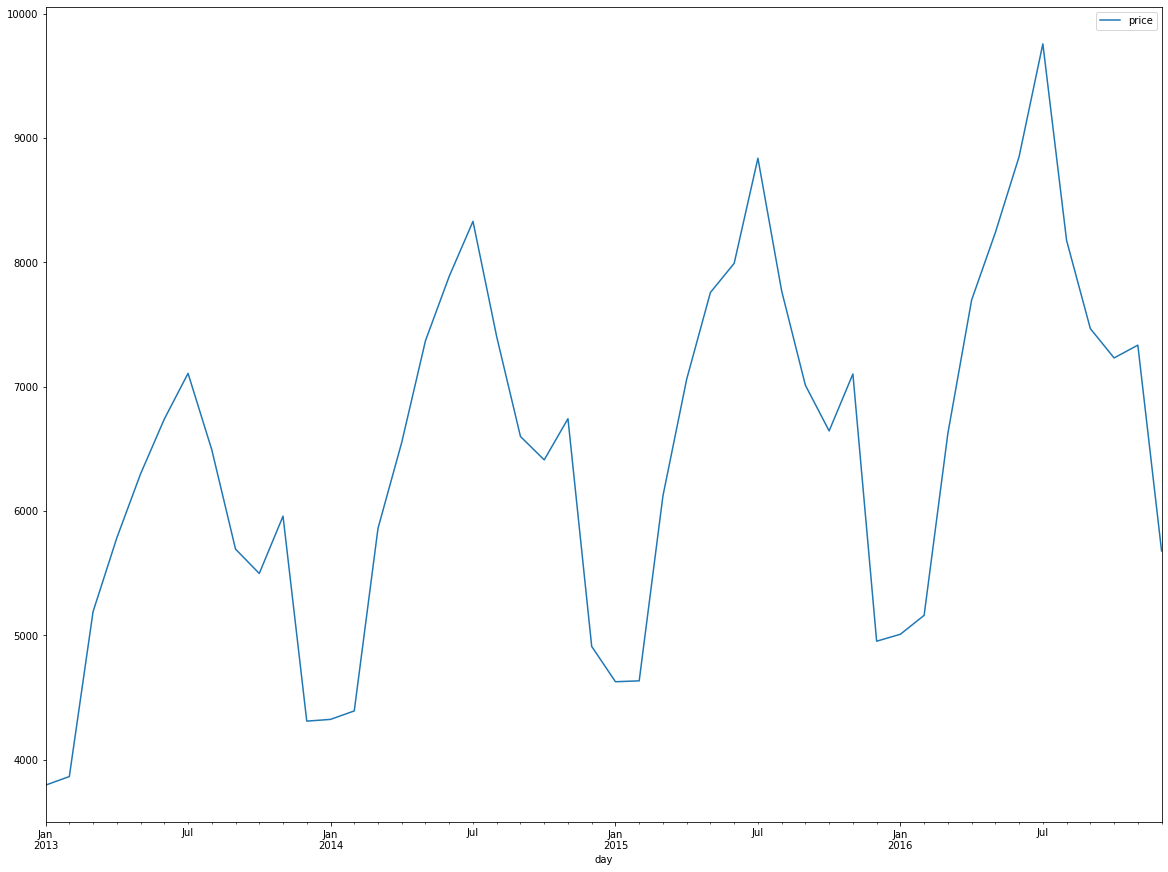

In [22]:
training.plot()

<AxesSubplot:xlabel='day'>

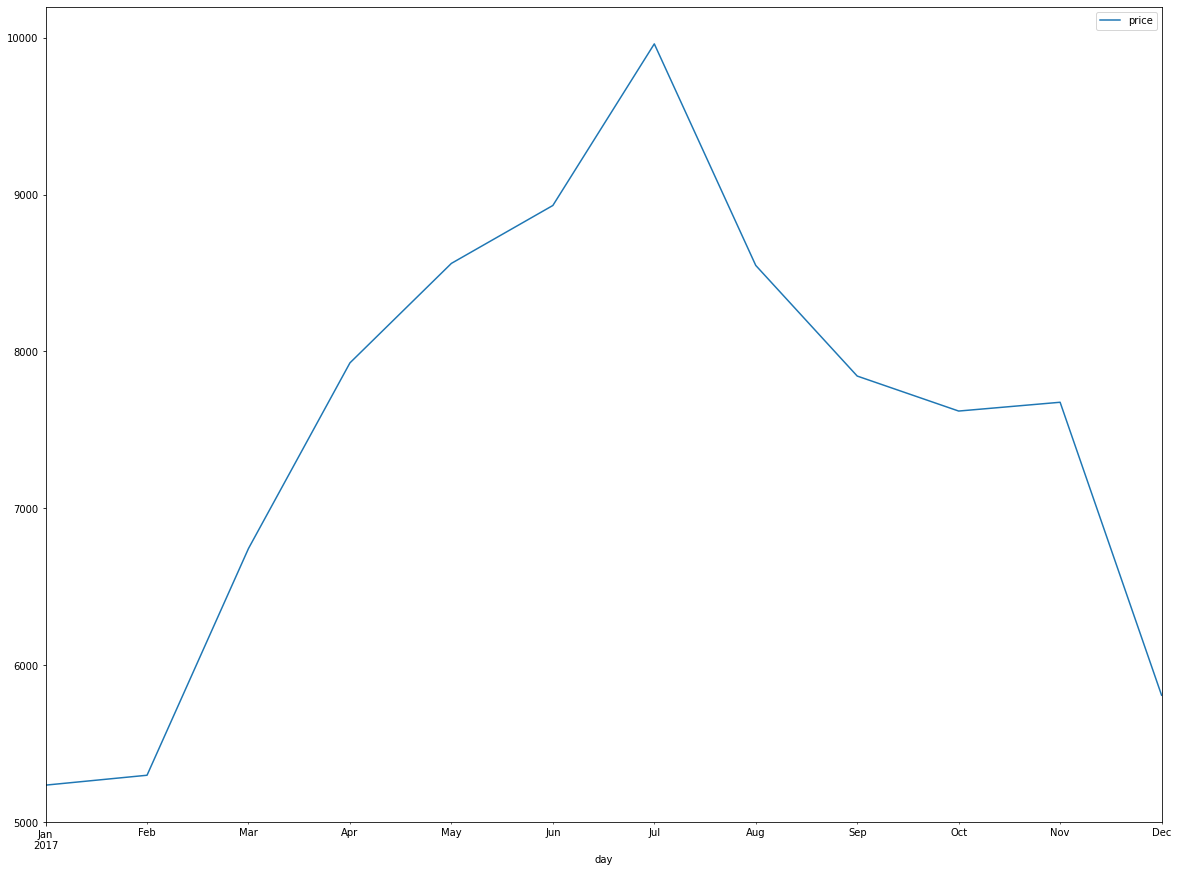

In [23]:
test.plot()

In [18]:
model = ARIMA(training, order=(2,1,2))
res = model.fit()
res.summary()

c:\Dev\Miniconda\envs\py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Dev\Miniconda\envs\py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Dev\Miniconda\envs\py38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Dev\Miniconda\envs\py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Dev\Miniconda\envs\py38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Sun, 06 Nov 2022   AIC                            761.750
Time:                        11:52:31   BIC                            771.001
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3167      0.190     -6.940      0.000      -1.689      -0.945
ar.L2         -0.3191      0.190     -1.675      0.094      -0.692       0.054
ma.L1          1.9700      0.243      8.121      0.000       1.495       2.445
ma.L2          0.9950      0.241      4.126      0.000       0.522       1.468
sigma2      4.453e+05   1.13e-06   3.93e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.35e+26. Standard errors may be unstable.
"""

- AIC는 작을 수록 좋다.
- AR, MA 모델의 p-value가 0.05 이하인지 확인 한다.

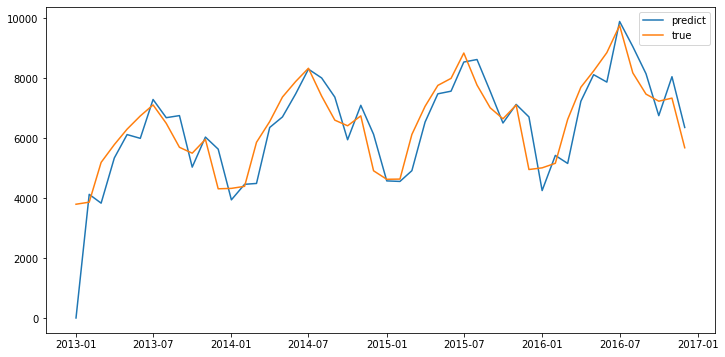

In [19]:
plt.figure(figsize=(12,6))
plt.plot(res.predict(), label='predict')
plt.plot(training, label='true')
plt.legend()
plt.show()

- 실제 값과 예측 값의 비교, 과소적합은 의심되지 않는다.
- 이 모델로 2017년의 데이터를 예측해 보자.
- 예측에는 predict() 보다 forecast() 를 주로 사용한다.

In [26]:
forecast = res.forecast(steps=len(test), alpha=0.05)
forecast

2017-01-01    6212.367190
2017-02-01    6581.113733
2017-03-01    7380.350347
2017-04-01    7231.765024
2017-05-01    7759.498997
2017-06-01    7473.437659
2017-07-01    7926.622858
2017-08-01    7605.177331
2017-09-01    8036.761416
2017-10-01    7707.363949
2017-11-01    8131.587395
2017-12-01    7801.602691
Freq: MS, Name: predicted_mean, dtype: float64

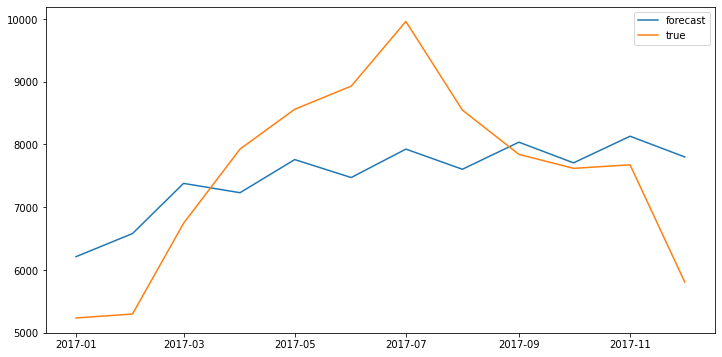

In [27]:
plt.figure(figsize=(12,6))
plt.plot(forecast, label='forecast')
plt.plot(test, label='true')
plt.legend()
plt.show()

- 그래프를 보면 예측이 성공적이지 않다.
- $R^2$와 RMSE도 확인해 본다

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

r2 = r2_score(test, forecast)
rmse = mean_squared_error(test, forecast)**0.5
print(f'r2_score : {r2}, RMSE : {rmse}')

r2_score : 0.3560735113805983, RMSE : 1136.3728171438004


- 계절정 지수가 추가된 경우, ARIMA 보다 SARIMA 를 사용하는 것이 좋다.

## SARIMA
### 개념
- 데이터가 지닌 계절성 (주기에 따라 유사한 양상으로 변화하는 모양)까지 고려한 ARIMA 모델
### 파이썬 실습 설명
- 계절성이 몇 개의 데이터 단위로 나타나는지를 먼저 확인 해야 한다.
- seasonal_order에서 4개의 매개변수가 주어져야 하는데, s 값을 먼저 찾아 준다.
- 이는 시각화로 판단 한다.
- 위의 예제 데이터는 1년 단위로 계절성이 존재 하는 것으로 보인다.
- 따라서 s는 12로 설정 한다.
- 나머지 P, D, Q는 grid_search를 지원 하는 auto_arima를 추가로 설치하여 찾는다.
#### auto_arima 설치

In [29]:
!pip install pmdarima

     -------------------------------------- 571.9/571.9 kB 6.0 MB/s eta 0:00:00
     -------------------------------------- 986.3/986.3 kB 7.0 MB/s eta 0:00:00


#### auto_arima 함수 호출

In [30]:
from pmdarima import auto_arima

#### 주요 매개변수

<img src="img/07-53.png" width="800"/>

- 계절에 대한 매개변수를 SARIMA 모델에서는 s, auto_arima에서는 m으로 사용한다.

#### auto_arima를 이용한 SARIMA
- 매개변수 중 trace는 결괏값에 학습정보를 표현하기 위해 True로 사용한다.

In [26]:
from pmdarima import auto_arima

auto_model = auto_arima(training, start_p = 0, d = 1, start_q = 0, 
                        max_p = 3, max_q = 3, start_P=0, start_Q = 0,
                        max_P = 3, max_Q = 3, m = 12,
                        seasonal=True, information_criterion='aic', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.17 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.16 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.40 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

- auto_arima 결과 : p = 0, d = 1, q = 1, P = 0, D = 1, Q = 0, m = 12 인 모델이 최적의 모델

In [23]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Sun, 06 Nov 2022   AIC                            480.687
Time:                                     11:54:54   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- AIC가 480.687 로 낮아짐
- SARIMA 모델로 다시 앞선 예측을 해본다.
- 단, auto_arima는 forecast()가 없어 predict()를 사용한다.

In [24]:
auto_pred = pd.DataFrame(auto_model.predict(n_periods=len(test)), index=test.index)
auto_pred.columns = ['predicted_price']
auto_pred

,predicted_price
day,
2017-01-01,5609.436977
2017-02-01,5761.436977
2017-03-01,7225.436977
2017-04-01,8298.436977
2017-05-01,8841.436977
2017-06-01,9452.436977
2017-07-01,10359.436977
2017-08-01,8777.436977
2017-09-01,8068.436977


- test 데이터와 예측 값을 비교하여 시각화 한다.

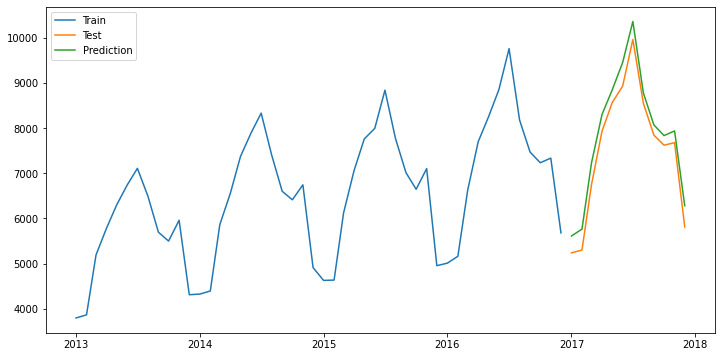

In [25]:
plt.figure(figsize=(12,6))
plt.plot(training, label='Train')
plt.plot(test, label='Test')
plt.plot(auto_pred, label='Prediction')
plt.legend()
plt.show()

- SARIMA가 ARIMA보다 더 높은 정확도임을 확인 할 수 있다.

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

r2 = r2_score(test, auto_pred)
rmse = mean_squared_error(test, auto_pred)**0.5
print(f'r2_score : {r2}, RMSE : {rmse}')

r2_score : 0.9305467067543264, RMSE : 373.20642594043227


- SARIMA : r2_score : 0.9305467069431359, RMSE : 373.2064254331493
- ARIMA : r2_score : 0.356239503120801, RMSE : 1136.226340284618
- 시계열 분석에서 추세 판단을 하는데는 ARIMA 모형이 정확도가 높을 수 있으나
- SARIMA가 계절성을 보이는 데이터의 경우 더 높은 정확도를 보인다.
- 그러나 SARIMA의 데이터 변수는 잘 선택해 주어야 한다.

[Kaggle Arima 문제 샘플](https://www.kaggle.com/code/kukuroo3/solution-python-problem3)